In [67]:
import scipy.io as sio
import matplotlib.pyplot as plt
import numpy as np
from sklearn import linear_model, neighbors,datasets
from lib.helpers import *
from sklearn import svm
from lib.cross_validations_lib import *
#import peakutils
import scipy.signal as signal
import numpy as np
from sklearn.decomposition import PCA,FastICA
from sklearn.cluster import MeanShift, estimate_bandwidth

In [68]:
def spli_matrix_two_blocks(y, percentage1, percentage2, seed):
    if(percentage1+percentage2==1):
        num_row = len(y)
        interval_1 = int(percentage1*num_row);
        
        np.random.seed(seed)
        indices = np.random.permutation(num_row);
        first_indices = indices[0:interval_1];
        second_indices = indices[interval_1:num_row];
        return [np.array(first_indices),np.array(second_indices)]
    else:
        print('>>>>>>>>>>>ERROR:Not valid splitting percentage')
    

In [69]:
def feature_extraction(signal,feature_dictionary,feature_extracted):
    feature=[]
    
    prototype_no_oxy=features_extracted["prototype_no_oxy"]
    prototype_yes_oxy=features_extracted["prototype_yes_oxy"]
    
    if(feature_dictionary["fft_max_frequencies"]==1):
        peak_signal=features_extracted["peak_signal"]
        f_peak_signal=peak_signal["f_cell"];
        cont=features_extracted["cont_peak"]
        f_peak=f_peak_signal[0,cont];
        feature=np.concatenate((feature,f_peak.reshape(f_peak.shape[1])), axis=0);

    if(feature_dictionary["distance_from_prototype"]==1):
        d_from_no=np.sum(np.square(signal-prototype_no_oxy))
        d_from_yes=np.sum(np.square(signal-prototype_yes_oxy))
        feature=np.concatenate((feature,[d_from_no]), axis=0)
        feature=np.concatenate((feature,[d_from_yes]), axis=0)
        
    if(feature_dictionary["mean"]==1):
        mean=np.mean(signal);
        feature=np.concatenate((feature,[mean]), axis=0)
    
    if(feature_dictionary["variance"]==1):
        variance=np.var(signal)
        feature=np.concatenate((feature,[variance]), axis=0)
    #crest factor 
    if(feature_dictionary["crest_factor"]==1):
        crest_factor=np.sum(np.power(signal,2))/signal.size
        feature=np.concatenate((feature,[crest_factor]), axis=0)
    return np.asarray(feature)
#.reshape([feature.size,1])

def extract_ICs(channel_structure,n_ICA_components):
    ica = FastICA(n_components=n_ICA_components,max_iter=10000)
    S_ = ica.fit_transform(channel_structure)  
    return S_
    
def extract_prototype(channel_structure,n_PCA_components):
    channel_structure_new=[];
    #using PCA 
    for time_instace in channel_structure:
        pca = PCA(n_components=n_PCA_components)
        time_instace_reduced=pca.fit_transform(time_instace.T);
        channel_structure_new.append(time_instace_reduced.T);
    
  
    channel_structure_new=np.concatenate(channel_structure_new,axis=0);

    # dim(channels_structure_new) = "number_of_reduced_sample" X "time_lenght"
    # if n_components=1 =" 30 X 80

    bandwidth = estimate_bandwidth(channel_structure_new, quantile=0.2, n_samples=len(channel_structure_new));
    ms = MeanShift(bandwidth=bandwidth, bin_seeding=True);
    ms.fit(channel_structure_new)
    prototype= ms.cluster_centers_
    return prototype.T



In [90]:
def export_signals(channels):
    time_instances=[];
    dim=channels.shape;
    #find the length min of the signal in the specified temporal instance
    # for NIRS signal ==80 
    length_min=len(channels[0,1]);
    for i in range (0,dim[1]):
        single_measurement=channels[0,i];
        single_length=single_measurement.shape[0]
        if(single_length<length_min):
                length_min=single_length;
    #export the signals
    for i in range (0,dim[1]):
        single_measurement=channels[0,i];
        dim1=single_measurement.shape;
        time_instance=[];
        for j  in range (0,dim1[1]):
            if(len(single_measurement[:,j])>length_min):
                single_signal=single_measurement[:,j][0:length_min]
            else:
                single_signal=single_measurement[:,j]
            #put in a list 
            time_instance.append(np.asarray(single_signal).reshape(len(single_signal),1).T);
       # create the matrix of the signals per a single time instance 
        time_instance=np.concatenate(time_instance);
        time_instances.append(time_instance);   

    return time_instances;



def get_feature_matrix_and_labels(channel_structure, feature_dictionary,label,features_extracted,n_ICA_components):
    list_train=[]
    list_labels=[]
    list_row=[]
    cont=0;
    flag=feature_dictionary["fft_max_frequencies"];
    index=0;
    for time_instance in channel_structure:
        index=index+1;
        feature_dictionary["fft_max_frequencies"]=flag;
        dim1=time_instance.shape
        #indipendent_components=extract_ICs(time_instance,n_ICA_components);
        for j  in range (0,dim1[0]):
            features_extracted["cont_peak"]=cont;
            features=feature_extraction(time_instance[j,:],feature_dictionary,features_extracted)
            list_row.append(features);
            cont=cont+1;
        """feature_dictionary["fft_max_frequencies"]=0;
        for single_component in indipendent_components:
            features=feature_extraction(single_component,feature_dictionary,features_extracted)
            list_row.append(features);"""
            
        labels=get_labels(1,label);
        feature_row=np.concatenate(list_row);
    
        list_train.append(feature_row.reshape(len(feature_row),1).T)
        list_labels.append(labels);
        list_row=[]

    
    train_TX=np.concatenate(list_train)
    labels=np.concatenate(list_labels,axis=0)
    
    return train_TX,labels.T.reshape(labels.size)


def get_feature_matrix(channels,feature_dictionary,features_extracted):
    list_train=[]
    list_labels=[]
    cont=0;
    peak_signal=features_extracted["peak_signal"]
    f_peak_signal=peak_signal["f_cell"];
    prototype_no_oxy=features_extracted["prototype_no_oxy"]
    prototype_yes_oxy=features_extracted["prototype_yes_oxy"]
    index=0;
    
    for time_instance in channel_structure:
        dim1=time_instace.shape
        print(dim1)
        for j  in range (0,dim1[0]):
            features=feature_extraction(time_instance[j,:],feature_dictionary,f_peak_signal[0,cont],prototype_no_oxy,prototype_yes_oxy)
            list_train.append([features]);
            cont=cont+1;
    train_TX=np.concatenate(list_train)
    return train_TX

def get_labels(number, string):
    if(string=="No"):
        return np.zeros(number)    
    if(string=="Yes"):
        return np.ones(number)
    
    
    
def select_features(weights,matrix,th):
    cont=0;
    i=0;
    while(cont<len(weights)):
        if(weights[cont]<th):

            mask = np.ones(matrix.shape[1], dtype=bool)
            mask[i] = False
            matrix=matrix[:,mask]
        else:
            i=i+1;
        cont=cont+1;
    return matrix
            
        
    

# OXY SIGNALS

PROTOTYPE OF YES


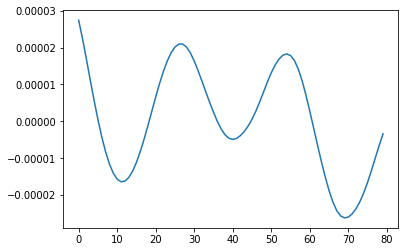

PROTOTYPE OF NO


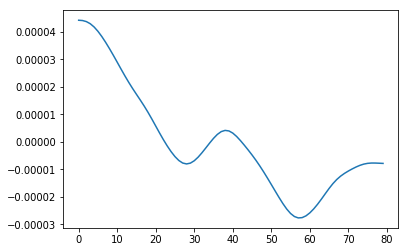

Train matrix shape
(60, 120)
Label array shape
(60,)


In [106]:
#parameters
n_ica_components=5;

#buildig the train matrix and labels
yes_oxy_contents = sio.loadmat('./segnali_belli/NIRSoxy_yesFasato.mat')
no_oxy_contents = sio.loadmat('./segnali_belli/NIRSoxy_noFasato.mat')
channels_no=no_oxy_contents["nofasato"]
channels_yes=yes_oxy_contents["yesfasato"]


#peak on NIRS
peak_yes_oxy_contents = sio.loadmat('pick_NIRSOxy_yes_signal.mat')
peak_no_oxy_contents = sio.loadmat('pick_NIRSoxy_no_signal.mat')

#explore with Mean_shift


# yes signals
channels_structure_yes_OXY=export_signals(channels_yes)
prototype_yes_oxy= extract_prototype(channels_structure_yes_OXY,3)
print("PROTOTYPE OF YES")
plt.plot(prototype_yes_oxy)
plt.show()

# no signals
channels_structure_no_OXY=export_signals(channels_no)
prototype_no_oxy= extract_prototype(channels_structure_no_OXY,3)
print("PROTOTYPE OF NO")
plt.plot(prototype_no_oxy)
plt.show()
    #select which feature select
    
feature_dictionary = {
        "fft_max_frequencies" : 1, 
         "mean" : 1, 
         "variance" : 1,
         "crest_factor" : 1,
         "distance_from_prototype": 1
         }
feature_dictionary_temp=feature_dictionary;

features_extracted={
    "peak_signal" : peak_yes_oxy_contents,
    "prototype_no_oxy" : prototype_no_oxy,
    "prototype_yes_oxy" : prototype_yes_oxy
}


train_TX_yes_oxy,labels_yes=get_feature_matrix_and_labels(channels_structure_yes_OXY, feature_dictionary,"Yes",features_extracted,n_ica_components);

    
feature_dictionary = feature_dictionary_temp


features_extracted={
    "peak_signal" : peak_no_oxy_contents,
    "prototype_no_oxy" : prototype_no_oxy,
    "prototype_yes_oxy" : prototype_yes_oxy
}
train_TX_no_oxy,labels_no=get_feature_matrix_and_labels(channels_structure_no_OXY, feature_dictionary,"No",features_extracted,n_ica_components);
train_TX=np.concatenate((train_TX_yes_oxy,train_TX_no_oxy),axis=0)

print("Train matrix shape")
print(train_TX.shape)

labels=np.concatenate((labels_yes,labels_no),axis=0)
print("Label array shape")
print(labels.shape)

In [107]:
def cross_validation_logistic_regularized(Y,X, degrees, lambdas, k_fold, seed, max_iters):
    
    # Get the indices so that we get the k'th subgroup in test, others in train, for each k
    k_indices = build_k_indices(Y, k_fold, seed)
    
    # Initialize matrix of computed accuracies for each degree and each fold
    accuracies_train_by_fold = np.zeros([len(degrees), len(lambdas), k_fold])
    accuracies_test_by_fold = np.zeros([len(degrees), len(lambdas), k_fold])
    coeff_matrix=np.zeros([X.shape[1], k_fold])
    best_features_subset=[];
    
    for k in range(k_fold):
        print('--- Fold', k, '---')
        # Create the testing set for this fold number
        k_index = k_indices[k] # Indices of the testing set for fold k
        Y_cross_val_test = Y[k_index]
        X_cross_val_test = X[k_index,:]
        
        
        # Create the training set for this fold number
        mask = np.ones(len(Y), dtype=bool) # set all elements to True
        mask[k_index] = False # set test elements to False
        Y_cross_val_train = Y[mask] # select only True elements (ie train elements)
        X_cross_val_train = X[mask,:]
       
        # Compute the accuracies for each degree
        accuracies_train_by_fold[:,:,k], accuracies_test_by_fold[:,:,k],coeff_matrix[:,k]= cross_validation_one_fold_logistic_regularized\
            (Y_cross_val_train, Y_cross_val_test, X_cross_val_train, X_cross_val_test, \
                                 degrees, lambdas,max_iters)
    
    # Compute the mean accuracies over the folds, for each degree
    
    
    mean_accuracies_train_by_deg = np.mean(accuracies_train_by_fold, axis=2)
    mean_accuracies_test_by_deg = np.mean(accuracies_test_by_fold, axis=2)
    
    # Get the index of the best accuracy in the testing set
    max_id_deg_test,max_id_lambda = \
        np.unravel_index(mean_accuracies_test_by_deg.argmax(), mean_accuracies_test_by_deg.shape)
    
    # Find the optimal degree and the corresponding accuracies in the training and testing sets
    best_deg = degrees[max_id_deg_test]
    best_lambda=lambdas[max_id_lambda]
    best_accuracy_test = mean_accuracies_test_by_deg[max_id_deg_test,max_id_lambda]
    corresponding_accuracy_train = mean_accuracies_train_by_deg[max_id_deg_test,max_id_lambda]
    
    coeff_mean=np.mean(coeff_matrix,axis=1)
    plt.plot(coeff_mean,'bo')
    plt.show()
   
    
    print('Best accuracy test =', best_accuracy_test, 'with degree =', best_deg , 'lambda=',best_lambda)
    print('Corresponding accuracy train =', corresponding_accuracy_train)
    
    return best_deg, best_lambda, best_accuracy_test, corresponding_accuracy_train ,coeff_mean                       


def cross_validation_one_fold_logistic_regularized(y_cross_val_train, y_cross_val_test, tx_cross_val_train, tx_cross_val_test, \
                                 degrees, lambdas, max_iters):
    

    accuracies_train_by_deg = np.zeros([len(degrees),len(lambdas)])
    accuracies_test_by_deg = np.zeros([len(degrees),len(lambdas)])
    coeff_ = np.zeros(tx_cross_val_train.shape[1])
    
    # For each degree, compute the least squares weights, the predictions and the accuracies
    for deg_id, deg in enumerate(degrees):
        print('++ Degree', deg, '++')
                
        # Add powers of the chosen columns
        len_data = tx_cross_val_train.shape[1]
        tx_cross_val_train = add_powers(tx_cross_val_train,deg )
        tx_cross_val_test = add_powers(tx_cross_val_test,deg)

  
        sum_of_accuracy=0;
        
        for lambda_id, single_lambda in enumerate(lambdas):
                
                print('>> Lambda', single_lambda, '<<')
                # Compute the best weights on the training set
                logreg = linear_model.LogisticRegression(penalty='l1',C=1/single_lambda, class_weight="balanced",max_iter=max_iters)
                logreg.fit(tx_cross_val_train,y_cross_val_train )

                # Compute the predictions
                y_predicted_cross_val_train = logreg.predict(tx_cross_val_train)
                y_predicted_cross_val_test = logreg.predict(tx_cross_val_test)
                
                #store the coefficents
                


                # Compute the accuracies for each degree
                accuracies_train_by_deg[deg_id,lambda_id] = \
                    np.sum(y_predicted_cross_val_train == y_cross_val_train)/len(y_cross_val_train)
                accuracies_test_by_deg[deg_id,lambda_id] = \
                    np.sum(y_predicted_cross_val_test == y_cross_val_test)/len(y_cross_val_test)
                coeff_ =np.abs(logreg.coef_)*accuracies_train_by_deg[deg_id,lambda_id]+coeff_;
                sum_of_accuracy=sum_of_accuracy+accuracies_train_by_deg[deg_id,lambda_id];
                
                

                

                print('Accuracy test =',accuracies_test_by_deg[deg_id,lambda_id])
        
    coeff_by_fold= coeff_/sum_of_accuracy;
        
    return accuracies_train_by_deg, accuracies_test_by_deg,coeff_by_fold



(60, 41)
--- Fold 0 ---
++ Degree 1 ++
>> Lambda 1e-08 <<
Accuracy test = 1.0
>> Lambda 1.58489319246e-07 <<
Accuracy test = 1.0
>> Lambda 2.51188643151e-06 <<
Accuracy test = 1.0
>> Lambda 3.98107170553e-05 <<
Accuracy test = 1.0
>> Lambda 0.00063095734448 <<
Accuracy test = 0.666666666667
>> Lambda 0.01 <<
Accuracy test = 0.666666666667
--- Fold 1 ---
++ Degree 1 ++
>> Lambda 1e-08 <<
Accuracy test = 0.333333333333
>> Lambda 1.58489319246e-07 <<
Accuracy test = 0.666666666667
>> Lambda 2.51188643151e-06 <<
Accuracy test = 0.666666666667
>> Lambda 3.98107170553e-05 <<
Accuracy test = 0.333333333333
>> Lambda 0.00063095734448 <<
Accuracy test = 0.666666666667
>> Lambda 0.01 <<
Accuracy test = 1.0
--- Fold 2 ---
++ Degree 1 ++
>> Lambda 1e-08 <<
Accuracy test = 0.666666666667
>> Lambda 1.58489319246e-07 <<
Accuracy test = 0.666666666667
>> Lambda 2.51188643151e-06 <<
Accuracy test = 0.666666666667
>> Lambda 3.98107170553e-05 <<
Accuracy test = 0.666666666667
>> Lambda 0.00063095734448 <

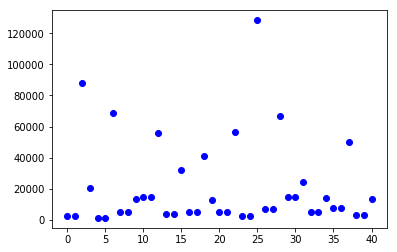

Best accuracy test = 0.616666666667 with degree = 1 lambda= 1.58489319246e-07
Corresponding accuracy train = 1.0


In [109]:
### REGULARIZATION
degrees = np.array([1])
lambdas = np.logspace(-8,-2,6)
k_fold=20

seed = 21
max_iters = 5000
print(train_TX.shape)

best_deg,best_lambda, best_accuracy_test, corresponding_accuracy_train,coeff_mean = \
        cross_validation_logistic_regularized(labels,train_TX, degrees, lambdas, k_fold, seed, max_iters)
    
th=np.mean(np.abs(coeff_mean/2))
train_TX=select_features(coeff_mean,train_TX,th)


In [110]:
#LOGISTIC 

max_iters = 100000
[i1,i2]=spli_matrix_two_blocks(train_TX,0.7,0.3,2)

# TRAIN SET 

train=train_TX[i1,:]
labels_train=labels[i1]

# TEST SET
test= train_TX[i2,:]
labels_test=labels[i2]




logreg = linear_model.LogisticRegression(penalty='l1',C=1/best_lambda,max_iter=max_iters)


logreg.fit(train, labels_train)  
predicted_labels= logreg.predict(test)


logistic_accuracy=get_accuracy(predicted_labels, labels_test)
print(logistic_accuracy)



print(train_TX.shape)

0.444444444444
(60, 19)


# SVM on oxy

In [111]:

C_parameters= np.linspace(0.1,10,10)
k_fold=4 # number of k sub-folders to divide the set
seed = 1
max_iters = 10000
kernel_types=['linear', 'rbf', 'sigmoid']
print(train_TX.shape)
best_C, best_kernel_type ,best_accuracy_test, corresponding_accuracy_train = \
        cross_validation_SVM(labels,train_TX, C_parameters, kernel_types, k_fold, seed, max_iters)



(60, 19)
--- Fold 0 ---
>> Penalty parameter C 0.1 <<
>> Type of Kernel  linear <<
0.333333333333 0.555555555556
>> Type of Kernel  rbf <<
0.333333333333 0.555555555556
>> Type of Kernel  sigmoid <<
0.333333333333 0.555555555556
>> Penalty parameter C 1.2 <<
>> Type of Kernel  linear <<
0.333333333333 0.555555555556
>> Type of Kernel  rbf <<
0.333333333333 0.555555555556
>> Type of Kernel  sigmoid <<
0.333333333333 0.555555555556
>> Penalty parameter C 2.3 <<
>> Type of Kernel  linear <<
0.333333333333 0.555555555556
>> Type of Kernel  rbf <<
0.333333333333 0.555555555556
>> Type of Kernel  sigmoid <<
0.333333333333 0.555555555556
>> Penalty parameter C 3.4 <<
>> Type of Kernel  linear <<
0.333333333333 0.555555555556
>> Type of Kernel  rbf <<
0.333333333333 0.555555555556
>> Type of Kernel  sigmoid <<
0.333333333333 0.555555555556
>> Penalty parameter C 4.5 <<
>> Type of Kernel  linear <<
0.333333333333 0.555555555556
>> Type of Kernel  rbf <<
0.333333333333 0.555555555556
>> Type of 

In [112]:
from sklearn import svm
seeds=[1,2,4,213,31,1]
for seed in seeds:
    [i1,i2]=spli_matrix_two_blocks(train_TX,0.8,0.2,seed)

# TRAIN SET 

    train=train_TX[i1,:]
    labels_train=labels[i1]

# TEST SET
    test= train_TX[i2,:]
    labels_test=labels[i2]

    clf = svm.SVC(C=best_C, cache_size=200, class_weight=None, coef0=0.0,
        decision_function_shape='ovr', degree=3, gamma='auto', kernel=best_kernel_type,
        max_iter=-1, probability=False, random_state=None, shrinking=True,
        tol=0.001, verbose=False)


    clf.fit(train, labels_train)  
    predicted_labels= clf.predict(test)


    SVM_accuracy=get_accuracy(predicted_labels, labels_test)
    print(SVM_accuracy)

0.25
0.416666666667
0.416666666667
0.333333333333
0.75
0.25
